# L2. Extended Kalman Filter Localization 

### Define all the imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
pd.set_option('mode.chained_assignment', None)

In [3]:
from src.localization.dead_reckoning import DeadReckoning
from src.localization.EKF import ExtendedKalmanFilter

### Set dataset

In [4]:
# Define dataset to read
dataset = "data/MRCLAM_Dataset2" # Dataset
end_frame = 15000 # Extension of the dataset
robot = 'Robot3' # Robot

### Execute DR estimation

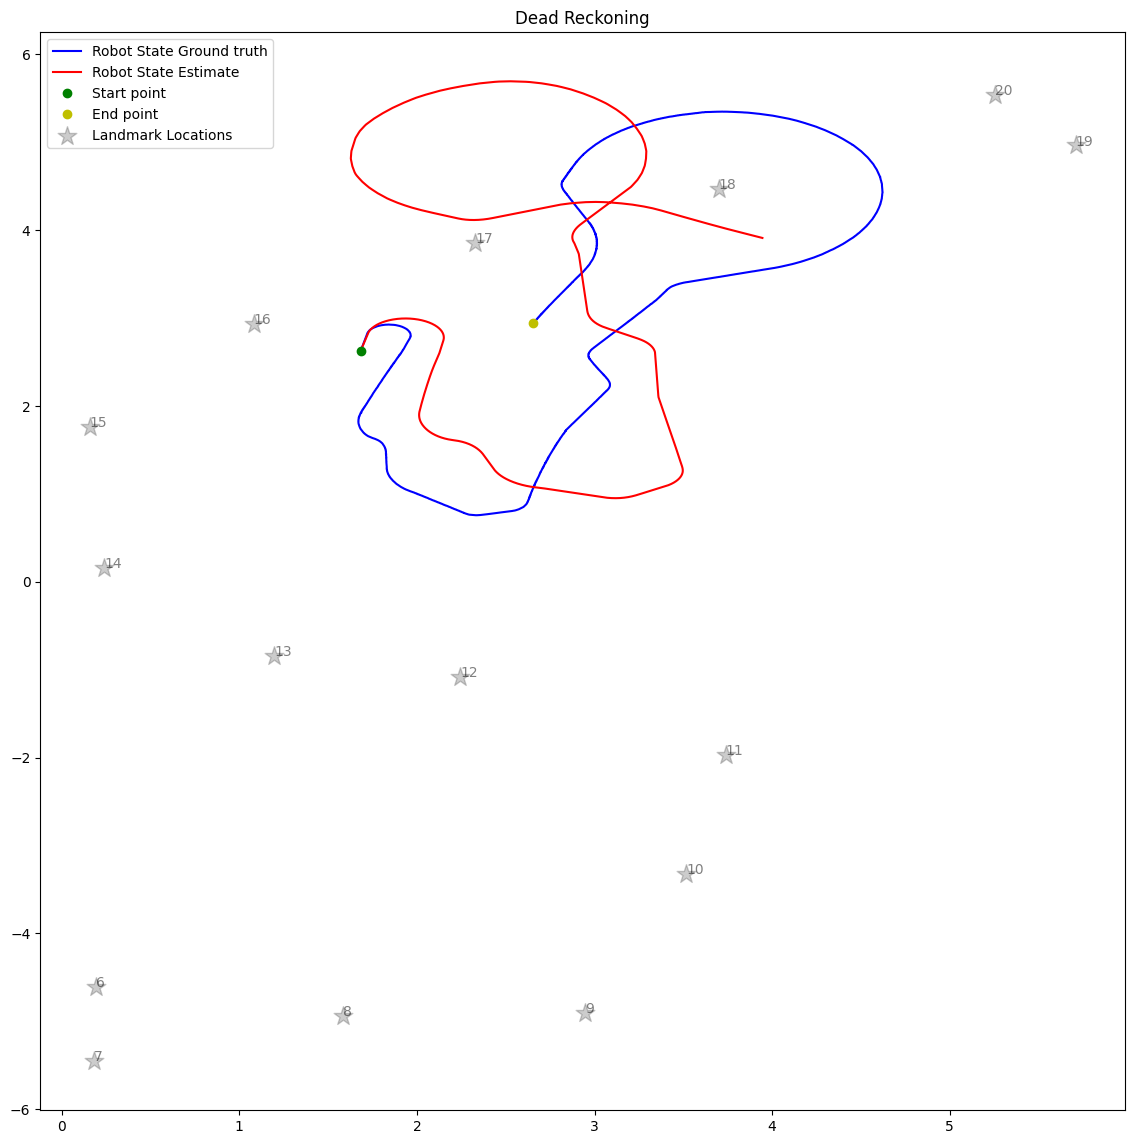

In [5]:
# Build dead reckoning object
dr = DeadReckoning(dataset, robot, end_frame)
dr.run()

### TASK 1. Execute EKF estimation.
Complete the extended kalman filter estimation code.

- R describe el *motion noise* y 
- Q describe el *measurement noise*.

R y Q son las correciones de error para las acciones y las measurements respectivamente.

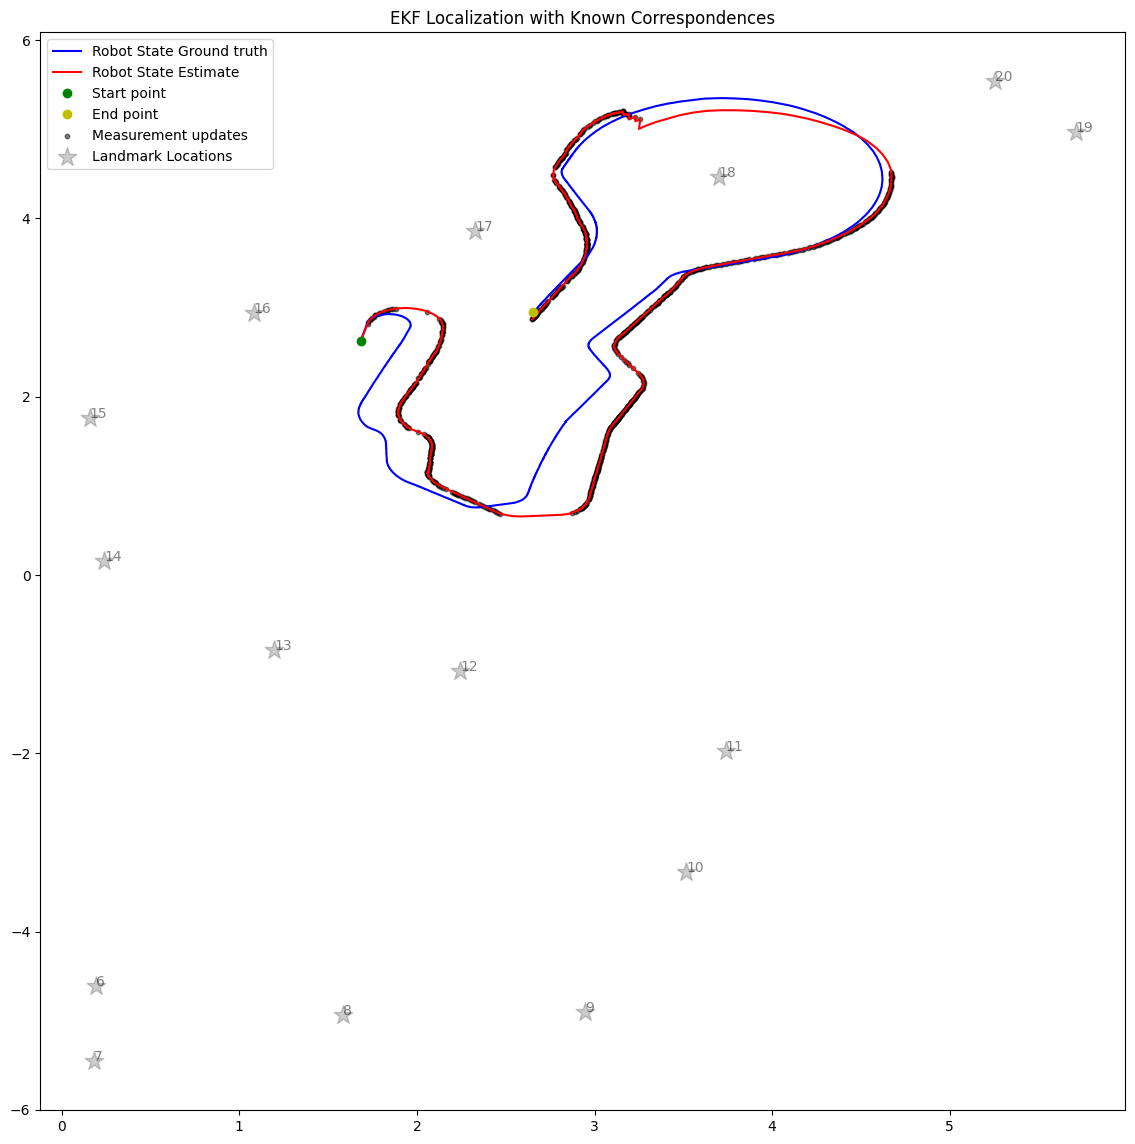

In [6]:
# Build Extended Kalman Filter object
R = np.diagflat(np.array([0.10, 0.10, 1.0]))** 2 
Q = np.diagflat(np.array([100, 100, 1e16]))** 2
ekf = ExtendedKalmanFilter(dataset, robot, end_frame, R, Q, True)

In [7]:
R 

array([[0.01, 0.  , 0.  ],
       [0.  , 0.01, 0.  ],
       [0.  , 0.  , 1.  ]])

In [8]:
Q

array([[1.e+04, 0.e+00, 0.e+00],
       [0.e+00, 1.e+04, 0.e+00],
       [0.e+00, 0.e+00, 1.e+32]])

### TASK 2. Compute path error metrics
1. Build a dataframe joining the GT with the dead reckoning and EKF state estimation.


2. Compute the $ATE$ using the groundtruth states $GT$, the dead reckoning estimated states $S_{DR}$ and the extended Kalman filter estimated states $S_{EKF}$.

The $ATE$ is then the root mean square error (RMSE) of the individual timestamp errors over the whole trajectory

And the $Delta$ represents the vector of displacements.

$Delta = GT[:-1] - GT[1:]$


### Construcción del dataframe *`gt_dr_kf`* (groundTruth_deadReckoning_extendedKalman_Filter)

In [9]:
# con esto nos evitamos ver la notación científica que a veces no es tan legible
np.set_printoptions(formatter={'all':lambda x: str(x)})

#### Construcción de los dataframes del algoritmo Dead Reckoning

Aprovechando la instancia de la clase DeadReckoning `dr`, 
construiremos los dataframes `dr.gt` y `dr.states` con el método `dr.build_dataframes()`.

Es cierto que crea más de los que necesitamos pero como ya está definido el método lo usamos.

In [10]:
dr.build_dataframes()
dr.gt

,x,y,theta
stamp,,,
2009-07-22 15:10:04.920999936,1.683462,2.628265,1.3663
2009-07-22 15:10:04.966000128,1.683418,2.628294,1.3663
2009-07-22 15:10:05.000000000,1.683385,2.628285,1.3663
2009-07-22 15:10:05.020999936,1.683394,2.628222,1.3663
2009-07-22 15:10:05.025000192,1.683424,2.628215,1.3663
...,...,...,...
2009-07-22 15:13:42.240000000,2.657970,2.951185,-1.9964
2009-07-22 15:13:42.275000064,2.657357,2.950709,-1.9944
2009-07-22 15:13:42.293999872,2.655836,2.948449,-1.9928


In [11]:
dr.states

,x,y,theta
stamp,,,
2009-07-22 15:10:04.920999936,1.683462,2.628265,1.366300
2009-07-22 15:10:04.938999808,1.683707,2.629446,1.366300
2009-07-22 15:10:04.980000000,1.684264,2.632135,1.366300
2009-07-22 15:10:05.010999808,1.684686,2.634169,1.366300
2009-07-22 15:10:05.030999808,1.684958,2.635481,1.366300
...,...,...,...
2009-07-22 15:13:42.299000064,3.941975,3.913576,-0.468465
2009-07-22 15:13:42.308999936,3.942572,3.913273,-0.468465
2009-07-22 15:13:42.328999936,3.943768,3.912668,-0.468425


Y los unimos como un dataframe temporal que llamaremos `tmp`.

Dejaremos puesta la coletilla de `_dr` a las etiquetas de `dr.states` para distinguirlos de `dr.gt`. 

In [12]:
tmp=dr.gt.join(dr.states, rsuffix='_dr').dropna()
tmp

,x,y,theta,x_dr,y_dr,theta_dr
stamp,,,,,,
2009-07-22 15:10:04.920999936,1.683462,2.628265,1.3663,1.683462,2.628265,1.366300
2009-07-22 15:10:08.379000064,1.721801,2.831794,1.2653,1.735027,2.860235,1.180434
2009-07-22 15:10:11.008999936,1.805327,2.920559,0.2314,1.894577,2.992075,0.181852
2009-07-22 15:10:11.172000000,1.813401,2.922999,0.1640,1.908418,2.994280,0.116978
2009-07-22 15:10:16.634000128,1.956318,2.756269,-1.8605,2.142412,2.702252,-1.721803
...,...,...,...,...,...,...
2009-07-22 15:13:40.620999936,2.706869,3.057278,-2.0106,3.841906,3.965019,-0.476478
2009-07-22 15:13:40.845999872,2.698325,3.042908,-1.9977,3.855306,3.958113,-0.475537
2009-07-22 15:13:41.060000000,2.693103,3.028954,-1.9989,3.868050,3.951542,-0.476914


De esta unión entre los dos dataframes tenemos que:
    
    - `df.gt`: 12913 rows
    - `df.states`: 13784 rows
    - `tmp`: el dataframe resultante queda con 683 rows

    
#### Construcción de los dataframes del algoritmo Extended Kalman Filter

Aprovechando la instancia de la clase ExtendedKalmanFilter `ekf`, 
construiremos el dataframe `ekf.states` con el método `ekf.build_dataframes()`.

Es cierto que crea más del que necesitamos pero como ya está definido el método lo usamos.

In [13]:
ekf.build_dataframes()
ekf.states

,x,y,theta
stamp,,,
2009-07-22 15:10:04.920999936,1.683462,2.628265,1.366300
2009-07-22 15:10:04.938999808,1.683707,2.629446,1.366300
2009-07-22 15:10:04.980000000,1.684264,2.632135,1.366300
2009-07-22 15:10:05.010999808,1.684686,2.634169,1.366300
2009-07-22 15:10:05.030999808,1.684958,2.635481,1.366300
...,...,...,...
2009-07-22 15:13:42.320000000,2.649940,2.868465,-1.981894
2009-07-22 15:13:42.321000192,2.649894,2.868496,-1.982042
2009-07-22 15:13:42.328999936,2.649680,2.868004,-1.982026


Y unimos `tmp` con `ekf.states` en un nuevo dataframe que llamaremos `gt_dr_kf`.

Dejaremos puesta la coletilla de `_kf` a las etiquetas de `ekf.states`.

Y a las 3 etiquetas de más a la izquierda les pondremos la coletilla de `_gt` correspondiente al *groundTruth*

In [14]:
gt_dr_kf = tmp.join(ekf.states,lsuffix='_gt',rsuffix='_kf').dropna()
gt_dr_kf

,x_gt,y_gt,theta_gt,x_dr,y_dr,theta_dr,x_kf,y_kf,theta_kf
stamp,,,,,,,,,
2009-07-22 15:10:04.920999936,1.683462,2.628265,1.3663,1.683462,2.628265,1.366300,1.683462,2.628265,1.366300
2009-07-22 15:10:08.379000064,1.721801,2.831794,1.2653,1.735027,2.860235,1.180434,1.733677,2.855913,1.186238
2009-07-22 15:10:11.008999936,1.805327,2.920559,0.2314,1.894577,2.992075,0.181852,1.869153,2.984398,0.298203
2009-07-22 15:10:11.172000000,1.813401,2.922999,0.1640,1.908418,2.994280,0.116978,1.882645,2.988195,0.233329
2009-07-22 15:10:16.634000128,1.956318,2.756269,-1.8605,2.142412,2.702252,-1.721803,2.146286,2.734981,-1.563861
...,...,...,...,...,...,...,...,...,...
2009-07-22 15:13:40.620999936,2.706869,3.057278,-2.0106,3.841906,3.965019,-0.476478,2.688763,2.960253,-1.979639
2009-07-22 15:13:40.845999872,2.698325,3.042908,-1.9977,3.855306,3.958113,-0.475537,2.682779,2.946417,-1.978698
2009-07-22 15:13:41.060000000,2.693103,3.028954,-1.9989,3.868050,3.951542,-0.476914,2.677284,2.934124,-1.981518


De esta unión entre los dos dataframes tenemos que:
    
    - `ekf.states`: 14728 rows
    - `tmp`: el dataframe temporal con 683 rows
    - `gt_dr_kf`: dataframe resultante con 683 rows y 9 columnas

### Calculamos $ATE$ y el $error\_final$

Usando los estados del Groundtruth `_gt`, los estados estimados del Dead Reckoning `_dr` y
los estados estimados del Extended Kalman Filter `_kf`.




#### Absolute Trajectory Error (ATE)

El *ATE* es la diferencia entre la trayectoria real y la trayectoria estimada.

Esta definido como el`root mean square error`o `rmse` de los errores de la distancias.

$$ATE_{rmse} = ATE = \sqrt{\dfrac{\sum_{i=1}^{n} (error\_d(i))²}{n}}$$

Donde `error_d(i)` el ***Error de distancia*** que mide la distancia entre cada pareja de puntos en el mismo instante.

Dicho de otro modo. Es la *norma*:

$$error\_d = \sqrt{ (error\_x)² + (error\_y)²}$$

Estos valores de `error_x` y `error_y` los obtenemos de los ***Errores en las coordenadas***.

Para cada valor obtenido a lo largo del tiempo que resultan de la diferencia entre la estimación y el valor real.

$$error\_x = \lvert{x - x\_gt}\rvert$$
$$error\_y = \lvert{y - y\_gt}\rvert$$

Y si hiciese falta para `theta`

$$error\_theta = \lvert{theta - theta\_gt}\rvert$$

In [15]:
# Dead Reckoning
# Errores en las coordenadas
gt_dr_kf['error_x_dr'] = abs(gt_dr_kf['x_gt']-gt_dr_kf['x_dr'])
gt_dr_kf['error_y_dr'] = abs(gt_dr_kf['y_gt']-gt_dr_kf['y_dr'])

# Error de distancia Dead Reckoning
gt_dr_kf['error_d_dr'] = np.sqrt(gt_dr_kf['error_x_dr']**2 + gt_dr_kf['error_y_dr']**2)


# Extended Kalman Filter

# Errores en las coordenadas
gt_dr_kf['error_x_kf'] = abs(gt_dr_kf['x_gt']-gt_dr_kf['x_kf'])
gt_dr_kf['error_y_kf'] = abs(gt_dr_kf['y_gt']-gt_dr_kf['y_kf'])

# Error de distancia EKF
gt_dr_kf['error_d_kf'] = np.sqrt(gt_dr_kf['error_x_kf']**2 + gt_dr_kf['error_y_kf']**2)

gt_dr_kf.tail()

,x_gt,y_gt,theta_gt,x_dr,y_dr,theta_dr,x_kf,y_kf,theta_kf,error_x_dr,error_y_dr,error_d_dr,error_x_kf,error_y_kf,error_d_kf
stamp,,,,,,,,,,,,,,,
2009-07-22 15:13:40.620999936,2.706869,3.057278,-2.0106,3.841906,3.965019,-0.476478,2.688763,2.960253,-1.979639,1.135037,0.907741,1.453376,0.018106,0.097025,0.098700
2009-07-22 15:13:40.845999872,2.698325,3.042908,-1.9977,3.855306,3.958113,-0.475537,2.682779,2.946417,-1.978698,1.156981,0.915205,1.475197,0.015546,0.096491,0.097735
2009-07-22 15:13:41.060000000,2.693103,3.028954,-1.9989,3.868050,3.951542,-0.476914,2.677284,2.934124,-1.981518,1.174946,0.922588,1.493877,0.015820,0.094830,0.096140
2009-07-22 15:13:41.152000000,2.690032,3.023138,-2.0014,3.873526,3.948712,-0.476593,2.676046,2.931104,-1.983576,1.183494,0.925574,1.502446,0.013986,0.092034,0.093091
2009-07-22 15:13:42.339000064,2.655923,2.944824,-1.9985,3.944366,3.912366,-0.468355,2.649412,2.867390,-1.981956,1.288443,0.967542,1.611279,0.006511,0.077434,0.077707


### Calculamos ahora el Absolute Trajectory Error (ATE)


$$ATE = \sqrt{\dfrac{\sum_{i=1}^{n} (error\_d(i))²}{n}}$$

In [16]:
# Absolute Trajectory Error (ATE)

# data.shape[0] me devolverá el número de filas de dataframe
# Viene a ser lo mismo que len(data)

n = gt_dr_kf.shape[0] 

ate_dr = np.sqrt((gt_dr_kf['error_d_dr']**2).sum()/n)
ate_kf = np.sqrt((gt_dr_kf['error_d_kf']**2).sum()/n)

In [17]:
ate_dr

1.3806939245920062

In [18]:
ate_kf

0.1642409787207716

### Otro error que podemos calcular es el `error_final`

$$ error\_final = (posicion\_final\_estimada) - (posicion\_final\_gt)$$

Pero eso no es nada más y nada menos que el último valor de nuestro dataframe `gt_dr_kf`.

En concreto, o el `error_d_` (*error de distancia*), 
o los (*errores de coordenadas*) de x e y `error_x`, `error_y` respectivamente.

Basta mostrar la última fila de `gt_dr_kf`.

`gt_dr_kf.iloc[data.index[-1]]` o `gt_dr_kf.iloc[-1]` o `gt_dr_kf.tail(1)`

El mostrar la última fila y no un valor es porque podemos ver todos los tipos de error calculados antes:
    
    - Error en las coordenadas
    
$$error\_x = \lvert{x - x\_gt}\rvert$$
$$error\_y = \lvert{y - y\_gt}\rvert$$
    
    - Error de distancia

$$error\_d = \sqrt{ (error\_x)² + (error\_y)²}$$

In [19]:
# Dead Reckoning

# error_final
gt_dr_kf.iloc[-1][['error_x_dr', 'error_y_dr','error_d_dr']]

error_x_dr    1.288443
error_y_dr    0.967542
error_d_dr    1.611279
Name: 2009-07-22 15:13:42.339000064, dtype: float64

In [20]:
# Extended Kalman Filter

# error_final
gt_dr_kf.iloc[-1][['error_x_kf', 'error_y_kf','error_d_kf']]

error_x_kf    0.006511
error_y_kf    0.077434
error_d_kf    0.077707
Name: 2009-07-22 15:13:42.339000064, dtype: float64

### TASK 3. Iterate over diferent datasets
Here we are interested on executing multiple experiments using different robots and datasets and get the error from previous blocks for all the experiments and enable further analisis.

The iterative execution of different experiments will enable as to compare different localization algorithms on further lab sessions.

#### Generate metrics

In [21]:
'''
Cálculo de la longitud total 'real' del recorrido realizado por el robot
'''
def compute_length(data):
    try:
        
        # Calcular la diferencia entre puntos sucesivos
        dx = data['x_gt'].diff()
        dy = data['y_gt'].diff()
        
        # Calcular la distancia euclidiana entre puntos sucesivos y sumarlos
        distancias = np.sqrt(dx**2 + dy**2)
        length = distancias.sum()
        
        return length
    except Exception as e:
        print(f"Error al calcular: {str(e)}")
        return None  

'''

 Código principal

 Aquí iteraremos sobre 8 DataSets y sobre los 5 robots.
 Obtendremos (más o menos) las errores que hemos calculado antes.
 Por último lo guardaremos todo en un dataFrame 'errors' para su posterior
 análisis.
 
'''
datasets = ["data/MRCLAM_Dataset1",
            "data/MRCLAM_Dataset2",
            "data/MRCLAM_Dataset3",
            "data/MRCLAM_Dataset4",
            "data/MRCLAM_Dataset5",
            "data/MRCLAM_Dataset6",
            "data/MRCLAM_Dataset7",
            "data/MRCLAM_Dataset8"]
robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4',
          'Robot5']


results = pd.DataFrame(columns=['dataset',
                                'robot',
                                'length',
                                'duration',
                                'n_landmarks',
                                'm_density',
                                'df_size',
                                'ate_dr',
                                'ate_kf',
                                'final_error_dr',
                                'final_error_kf'])



# Vaciamos "por si acaso" el dataFrame metrics pero manteniendo las columnas
# metrics = pd.DataFrame(columns=metrics.columns)
end_frame = 15000 # Extension of the dataset
R = np.diagflat(np.array([0.1, 0.1, 1.0]))** 2 
Q = np.diagflat(np.array([100, 100, 1e16]))** 2
    
    
    
    
for ds in datasets:
    for rob in robots:
        # Vamos cargando los dataSets haciéndonos valer de la clase creada 
        # al inicio del notebook
        # Define dataset to read
        dataset = ds # Dataset
        robot = rob # Robot
        
        # Build Dead Reckoning object and dataframes
        dr = DeadReckoning(dataset, robot, end_frame)
        dr.plot = False
        dr.run()
        dr.build_dataframes()
        
        # Build Extended Kalman Filter object and dataframes
        # plot=False para no dibujar el trazado
        ekf = ExtendedKalmanFilter(dataset, robot, end_frame, R, Q, False)
        ekf.build_dataframes()
        
        #
        # Creamos el dataframe filtrado con los 3 conjuntos de coordenadas
        #
        tmp=dr.gt.join(dr.states, rsuffix='_dr').dropna()
        gt_dr_kf = tmp.join(ekf.states,lsuffix='_gt',rsuffix='_kf').dropna()
        
        
        #
        # Calculamos los errores finales
        #
        # Dead Reckoning
        # Errores en las coordenadas
        gt_dr_kf['error_x_dr'] = abs(gt_dr_kf['x_gt']-gt_dr_kf['x_dr'])
        gt_dr_kf['error_y_dr'] = abs(gt_dr_kf['y_gt']-gt_dr_kf['y_dr'])
        # Error de distancia Dead Reckoning
        gt_dr_kf['error_d_dr'] = np.sqrt(gt_dr_kf['error_x_dr']**2 + gt_dr_kf['error_y_dr']**2)

        # Extended Kalman Filter
        # Errores en las coordenadas
        gt_dr_kf['error_x_kf'] = abs(gt_dr_kf['x_gt']-gt_dr_kf['x_kf'])
        gt_dr_kf['error_y_kf'] = abs(gt_dr_kf['y_gt']-gt_dr_kf['y_kf'])
        # Error de distancia EKF
        gt_dr_kf['error_d_kf'] = np.sqrt(gt_dr_kf['error_x_kf']**2 + gt_dr_kf['error_y_kf']**2)

        #
        # Calculamos los ATE del Dead Reckoning y del EKF
        #
        # Absolute Trajectory Error (ATE)
        n = gt_dr_kf.shape[0] 

        ate_dr = np.sqrt((gt_dr_kf['error_d_dr']**2).sum()/n)
        ate_kf = np.sqrt((gt_dr_kf['error_d_kf']**2).sum()/n)


        # length = es la longitud total del recorrido real
        # realizado por el robot y que guarda esa información en el
        # pandas dataframe 'gt_dr_kf' en los que acaban en '_gt'
        # no elegimos 'dr.gt' por que no está filtrado
        length = compute_length(gt_dr_kf[['x_gt','y_gt']])
        # duration = la diferencia entre el inicio y final
        # de la toma de medidas
        # Las unidades son Epoch (Unix Time)
        duration = (gt_dr_kf.index[-1]-gt_dr_kf.index[0]).total_seconds()
        # n_landmarks = número de medidas de landmarks en el DataSet
        #n_landmarks = calculado en el dataframe 'sensor'
        # Está en dr y en ekf, elijo dr
        n_landmarks = dr.sensor.shape[0]
        # Densitat de mesures
        #m_density = calculate_m_density(data)
        m_density = n_landmarks / length
        #final_error_ds y final_error_kf
        error_dr = gt_dr_kf.iloc[-1]['error_d_dr']
        error_kf = gt_dr_kf.iloc[-1]['error_d_kf']

        
        # Añadimos un nuevo elemento al dataFrame metrics
        # al haber quedado obsoleto el método 'append' debo
        # crear una nueva fila y emplear el método 'concat' en su lugar.
        nueva_fila = {'dataset': ds, 
            'robot': rob, 
            'length': length, 
            'duration': duration, 
            'n_landmarks': n_landmarks, 
            'm_density': m_density,
            'df_size': n,
            'ate_dr': ate_dr,
            'ate_kf': ate_kf,
            'final_error_dr': error_dr,
            'final_error_kf': error_kf}

        results = pd.concat([results, pd.DataFrame([nueva_fila])], 
                            ignore_index=True)
results

,dataset,robot,length,duration,n_landmarks,m_density,df_size,ate_dr,ate_kf,final_error_dr,final_error_kf
0,data/MRCLAM_Dataset1,Robot1,12.902649,220.736999,765,59.290150,689,1.099417,1.149525,0.617786,0.893748
1,data/MRCLAM_Dataset1,Robot2,12.051001,214.829999,638,52.941659,742,0.654015,0.355563,1.671493,0.436065
2,data/MRCLAM_Dataset1,Robot3,12.188506,209.936000,961,78.844774,660,0.395521,0.184288,0.713192,0.127467
3,data/MRCLAM_Dataset1,Robot4,12.638087,222.202000,398,31.492107,683,0.438075,1.059813,0.266080,2.442456
4,data/MRCLAM_Dataset1,Robot5,12.554142,209.968000,922,73.441898,615,3.275590,0.494594,3.442972,0.820176
5,data/MRCLAM_Dataset2,Robot1,13.442600,217.220000,733,54.528144,910,2.771522,0.148567,6.147273,0.066833
6,data/MRCLAM_Dataset2,Robot2,13.418304,231.211000,783,58.353128,685,0.849809,0.335651,1.583218,0.099256
7,data/MRCLAM_Dataset2,Robot3,12.124627,217.418000,997,82.229331,683,1.380694,0.164241,1.611279,0.077707
8,data/MRCLAM_Dataset2,Robot4,11.377525,266.253999,620,54.493400,989,0.973905,0.130508,1.412916,0.214900
9,data/MRCLAM_Dataset2,Robot5,10.637510,218.504000,1284,120.704935,605,0.896545,0.347825,1.596023,0.918229


In [22]:
results.describe()

,length,duration,m_density,ate_dr,ate_kf,final_error_dr,final_error_kf
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,11.383864,218.784800,71.428898,1.064707,0.511074,1.615553,0.458075
std,1.684867,19.866328,30.045170,0.701072,0.721279,1.269659,0.625077
min,5.449347,186.749000,21.926255,0.302549,0.063536,0.044316,0.040213
25%,10.809672,202.474249,52.567315,0.634147,0.159977,0.918878,0.094983
50%,11.707681,216.450500,61.447578,0.892808,0.213426,1.438644,0.202609
75%,12.355279,229.573750,85.805310,1.169392,0.393939,1.754509,0.506340
max,14.588689,266.253999,146.446397,3.275590,3.268828,6.147273,2.536501


#### Represent metrics
For instance you could use the catplot of the seaborn library. Feel free to use another informative plot.

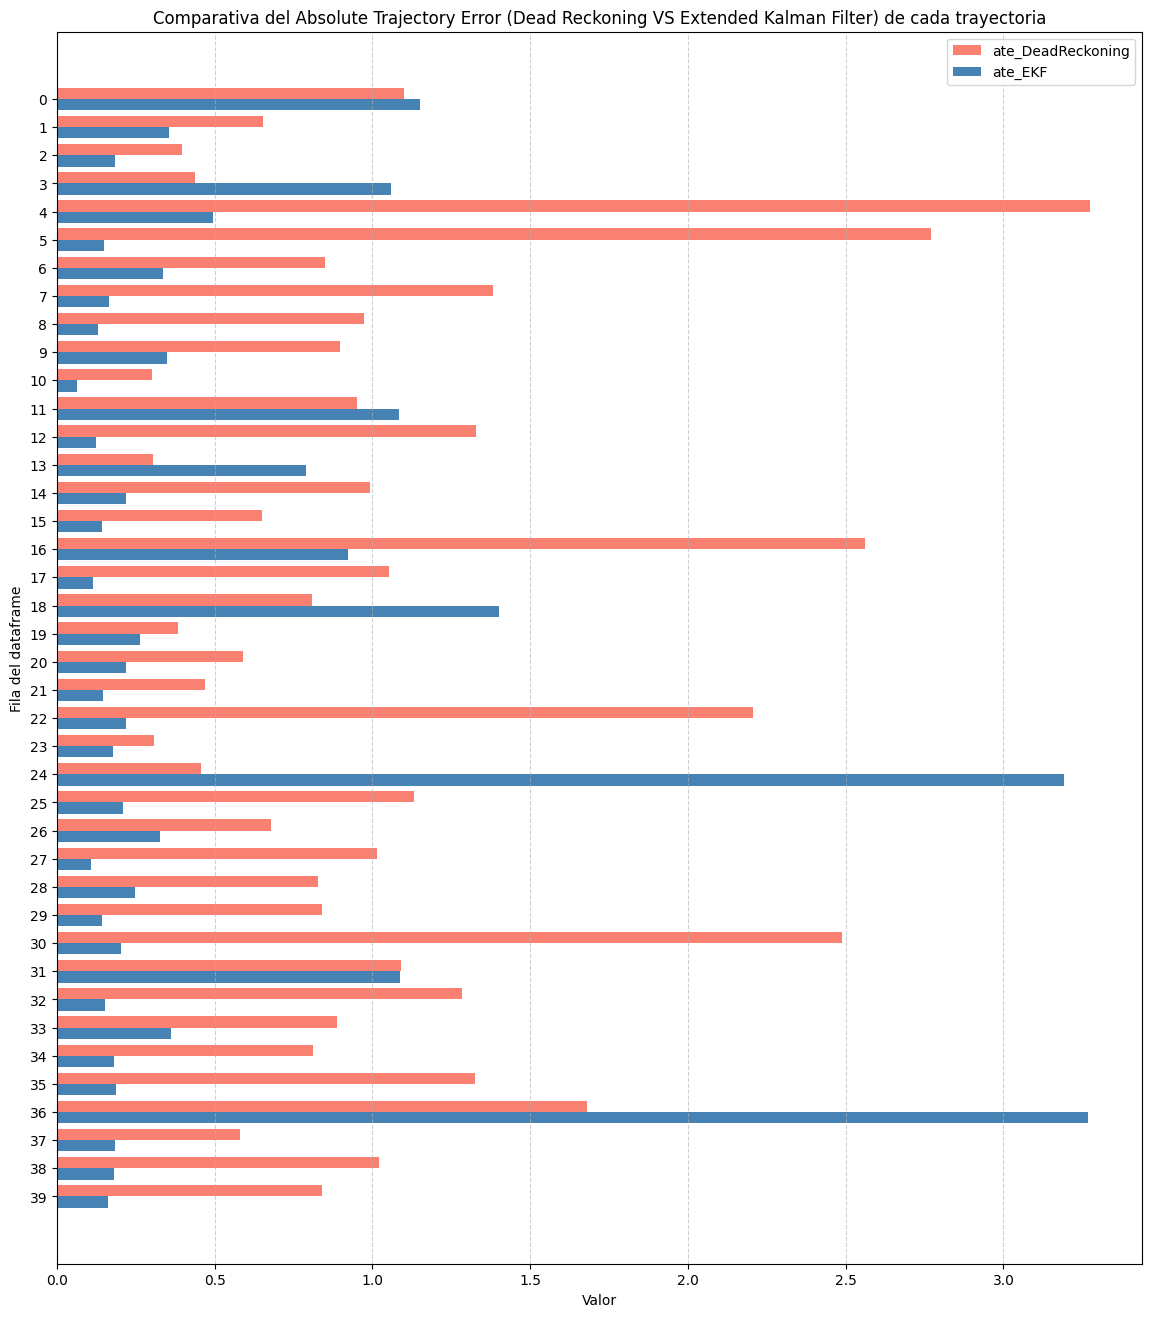

In [23]:
# Represent metrics for all experiments
#Tamaño de la gráfica
plt.figure(figsize=(14, 16))
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Configurar la posición de las barras
bar_width = 0.4
bar_positions_ate_dr = np.arange(len(results))
bar_positions_ate_kf = bar_positions_ate_dr + bar_width

# Crear barras horizontales para ate_dr y ate_kf para cada fila
plt.barh(bar_positions_ate_dr, results['ate_dr'], height=bar_width, color='salmon', label='ate_DeadReckoning')
plt.barh(bar_positions_ate_kf, results['ate_kf'], height=bar_width, color='steelblue', label='ate_EKF')

# Configurar etiquetas y leyenda
plt.yticks(bar_positions_ate_dr + bar_width / 2, results.index)
plt.title('Comparativa del Absolute Trajectory Error (Dead Reckoning VS Extended Kalman Filter) de cada trayectoria')
plt.xlabel('Valor')
plt.ylabel('Fila del dataframe')
plt.legend()

# Invertir el eje y para que la fila 0 esté arriba y la fila 39 abajo
plt.gca().invert_yaxis()

plt.show()

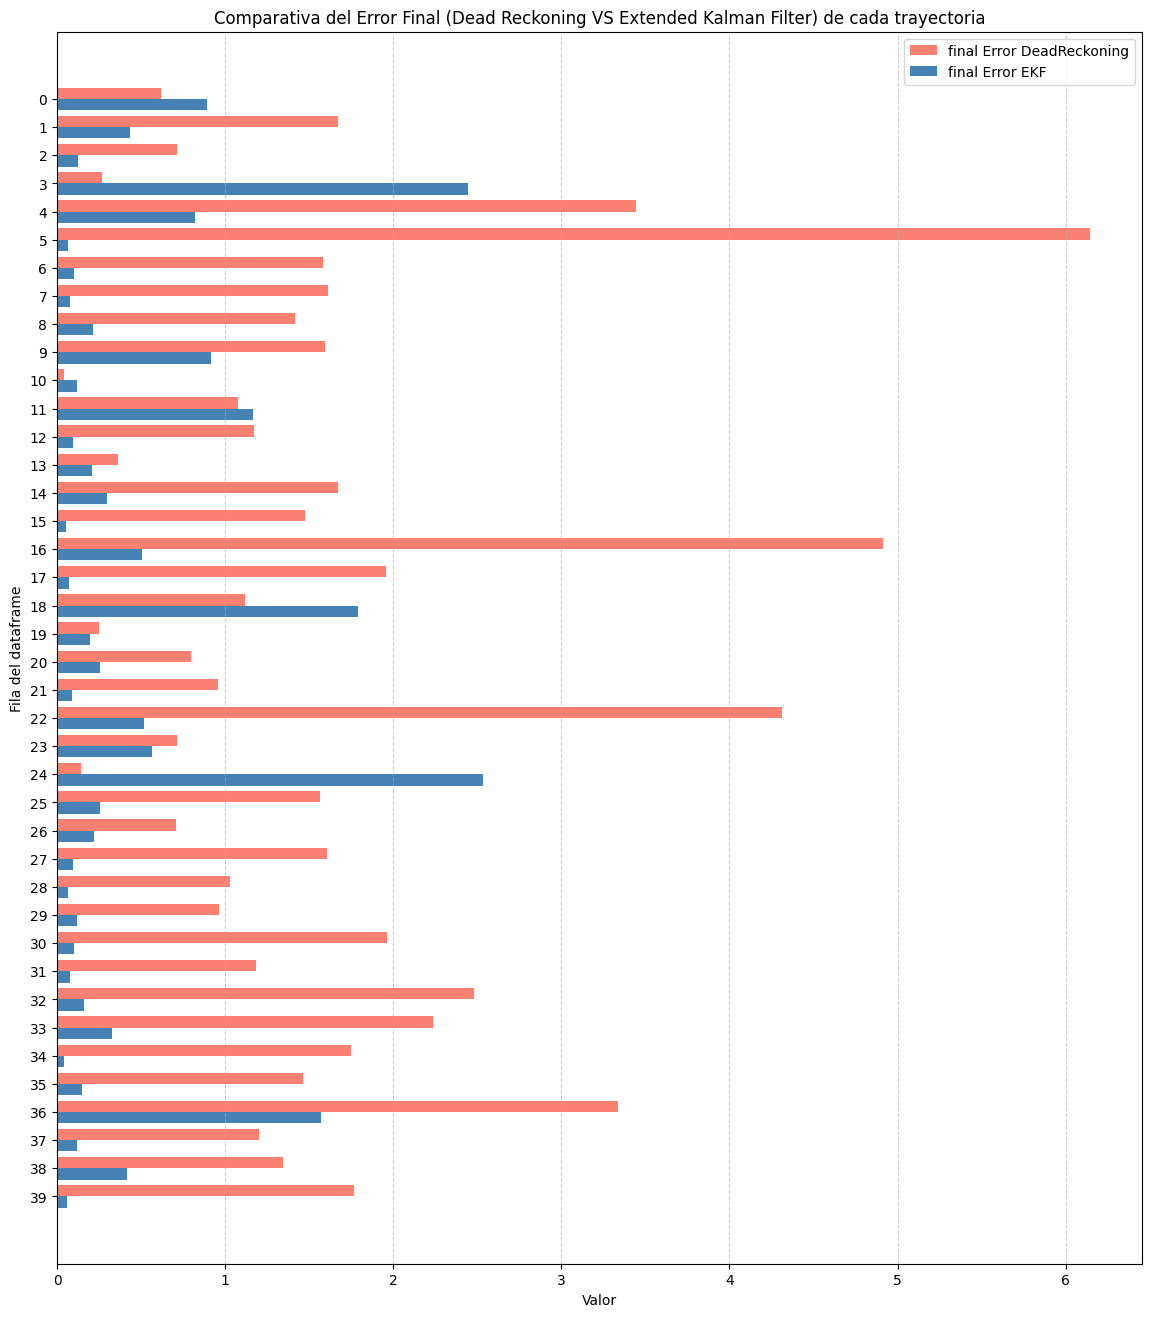

In [24]:
# Esta gráfica es la del error_final

#Tamaño de la gráfica
plt.figure(figsize=(14, 16))
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Configurar la posición de las barras
bar_width = 0.4
bar_positions_fe_dr = np.arange(len(results))
bar_positions_fe_kf = bar_positions_fe_dr + bar_width

# Crear barras horizontales para ate_dr y ate_kf para cada fila
plt.barh(bar_positions_fe_dr, results['final_error_dr'], height=bar_width, color='salmon', label='final Error DeadReckoning')
plt.barh(bar_positions_fe_kf, results['final_error_kf'], height=bar_width, color='steelblue', label='final Error EKF')

# Configurar etiquetas y leyenda
plt.yticks(bar_positions_ate_dr + bar_width / 2, results.index)
plt.title('Comparativa del Error Final (Dead Reckoning VS Extended Kalman Filter) de cada trayectoria')
plt.xlabel('Valor')
plt.ylabel('Fila del dataframe')
plt.legend()

# Invertir el eje y para que la fila 0 esté arriba y la fila 39 abajo
plt.gca().invert_yaxis()

plt.show()

## Analize metrics. Analize the results and provide the mean error metrics across the experiments performed.

### Asunciones iniciales
    
- Por un lado, y como podemos apreciar en las dos gráficas superiores, a diferencia de los 
anteriores *Laboratorios* no agrupamos ni por `DataSet_n` ni por `Robot_n`. 
Consideramos cada fila como una trayectoria única y distinta del resto, como lo que son.


- Por otro lado, y como derivado del apartado anterior la elección de nuestros mejores y peores escenarios 
no consideraremos tampoco `DataSet_n` ni `Robot_n`, simplemente nos referiremos al número de fila que viene 
referenciado como el índice del dataframe `results`. No tendría sentido de otra manera.

- Las pruebas realizadas se han realizado con un `end_frame = 15000`. Hablamos de que para cada *Dataset_n* 
se emplean 15000 transiciones temporales. Si los cambiamos por un valor de duración mayor o menor los resultados
serán distintos.

- Igualmente, y en concreto para el algoritmo *EKF*, las matrices de covarianza de estado `R` para la predicción, 
y la de medida `Q` para la corrección se definen tal que así:

$$ 
R =
{\begin{pmatrix}
0.1 & 0.0 & 0.0\\
0.0 & 0.1 & 0.0\\
0.0 & 0.0 & 1.0
\end{pmatrix}}^²
$$ 

$$
Q =
{\begin{pmatrix}
{10^2} & 0.0 & 0.0\\
0.0 & {10^2} & 0.0\\
0.0 & 0.0 & {10^{16}}
\end{pmatrix}}^²
$$



La modificación de estos valores puede cambiar drásticamente los resultados, lo confirmo ya que mientras
realizaba la pruebas de algunas trayectorias que me resultaron un tanto 'anormales' o 'erráticas' pudieron
corregirse, a la vez que las que antes estaban bien pasaban a desvariar o seguir rutas bastante 'imprevisibles'.


### Interpretación rápida

Tras un descripción estadística del dataframe `results.describe()` lo primero que podemos apreciar es que
en términos generales el algoritmo **Extended Kalman Filter** se comporta muchísimo mejor que el **Dead Reckoning**.
Basta ver tanto el `final_error_??` como el `ate_??` como son mucho menores (y por tanto mejores) los primeros 
(las etiquetas con el sufijo `_kf`).

Prueba que se confirma con un análisis visual de las dos gráficas que se muestran a continuación del 
análisis descriptivo. Cada una de las filas se corresponde exactamente con las filas del dataframe `results`.

Los resultados de la navegación por estima (o *Dead reckoning*) en color `salmon` y el *EKF* en color `steelblue`.

### Interpretación gráfica

La primera gráfica representan una comparativa entre los dos *ate* (`ate_dr` VS `ate_kf`). Donde en general, las
barras 'azules' son bastante más cortas que las de color 'salmón'.

Con la segunda gráfica representamos la comparativa entre los errores finales 
(`final_error_dr` VS `final_error_kf`). En general, son más largas las barras de color 'salmón' aunque aquí las 
diferencias no son tan visibles como en la anterior gráfica. El comportamiento no tiene porqué seguir el mismo 
patrón. E incido en que no tiene porqué. Y es que el **ate** es un error cuadrático ($x²$) que hace que los valores
atípicos tengan más peso y sean más "penalizado". La diferencias entre unos y otros se acentúan mucho.
Un ejemplo muy claro lo vemos en la fila/muestra *36*: 

 $$final\_error\_kf_{36} < final\_error\_dr_{36}$$
    $$ \wedge $$
 $$ate\_kf_{36} >> ate\_dr_{36}$$

### Un poco más allá

Si atendemos a la densidad de las medidas `m_density` que la obtenemos de la longitud del trazado y el número de 
landmarks 'vistos' en el camino:
    
$$m\_density = \dfrac{n\_landmarks} {length}$$
    
En el análisis descriptivo nos indica que la media de densidad `m_density = 71.4`. Si Atendiendo, a este número, 
podemos inferir que para el algoritmo `EKF`: 
    
- Las muestras que estén por debajo, el error cometido será mayor que,

- Las muestras que estén por encima, el error cometido será menor

Está claro que existen excepciones, como en todo. Nos encontramos con muestras que no cumplen estas condiciones, 
pero no representan la mayoría. Aunque la cantidad de muestras no es muy grande, podemos decir que es una muestra 
casi *característica*.

Otra de las pruebas que realicé fue la aumentar la duración de las pruebas. Esto implica tomas más valores
para ello he cambiado el valor de `end_frame` a los valores 5000 y 35000. Estos cambios
no han hecho más que confirmar lo anteriormente dicho. Cuando tenemos pocas muestras, las diferencias de los errores
entre uno y otro algoritmo son muy indistinguibles:
    
- Cuando `end_frame = 5000`: Mientras que el algoritmo Dead Reckoning su comportamiento es similar, 
sea cual sea la duración, el del EKF la verdad es que no es muy bueno cuando tratamos con sólo 5000.

- Cuando `end_frame = 35000`: Aquí si que hemos notado un cambio bastante grande. El algoritmo Dead Reckoning se
comportaba igual (de bien o de mal) mientras que en el algoritmo EKF los errores (ate y final_error) han bajado.


A continuación, vamos a mostrar la representación gráfica de los dos escenarios (el mejor y el peor) para el 
algoritmo del **Extended Kalman Filter** comparándolo con su representación de navegación por estima (o **Dead Reckoning).

La elección que haremos será la siguiente:
    
- Para el escenario del peor caso elegimos la fila 24.

- Para el escenario del mejor caso elegimos la fila 5.


### Escenario del Peor Caso (Worst Case Scenario). Fila 24

Esta fila se corresponde al dataset `data/MRCLAM_Dataset5` y al `Robot5`

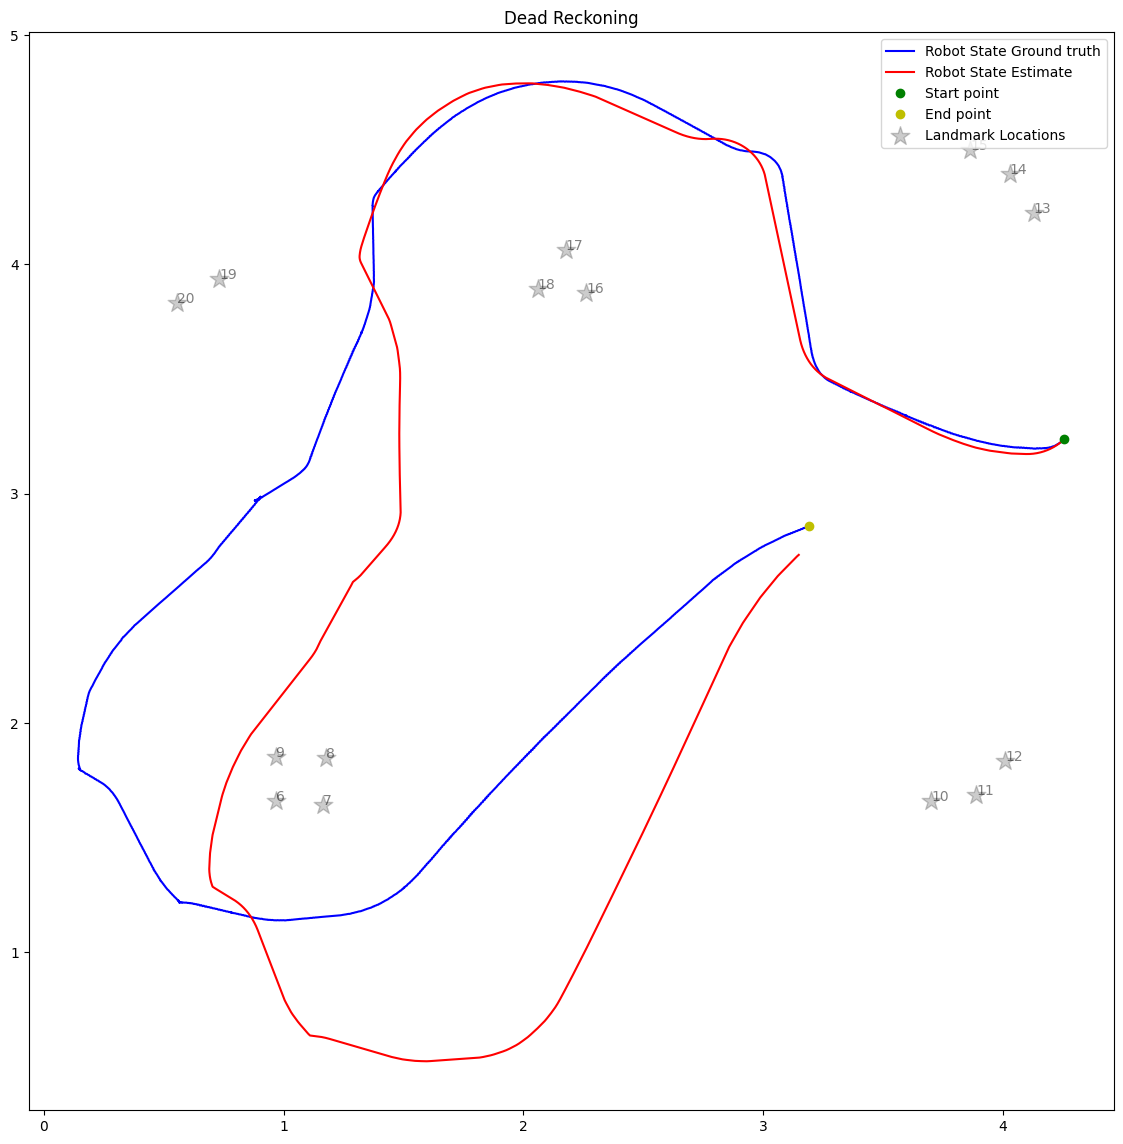

In [25]:
# Define dataset to read
dataset = "data/MRCLAM_Dataset5" # Dataset
end_frame = 15000 # Extension of the dataset
robot = 'Robot5' # Robot

# Build dead reckoning object
dr = DeadReckoning(dataset, robot, end_frame)
dr.run()

En este caso vemos que el algoritmo `Dead Reckoning` funciona bastante bien en lo que se refiere
a estimar la localización. 

Como ya sabemos, esta técnica va calculando sobre sus datos "odométricos" (en realidad no, son de velocidad 
lineal y angular) la siguiente posición (relativa) mediante operaciones geométricas muy simples.
La siguiente posición será calculada en función de la anterior. En nuestro algoritmo `DeadReckoning.py` 
hacemos coincidir su posición inicial (relativa) con la absoluta o *groundtruth*.

Con esta representación vemos que las medidas odométricas son bastante ajustadas por lo que podemos decir que no 
está del todo mal.

Ahora veamos para esta misma trayectoria como se comporta el algoritmo `Extended Kalman Filter`.

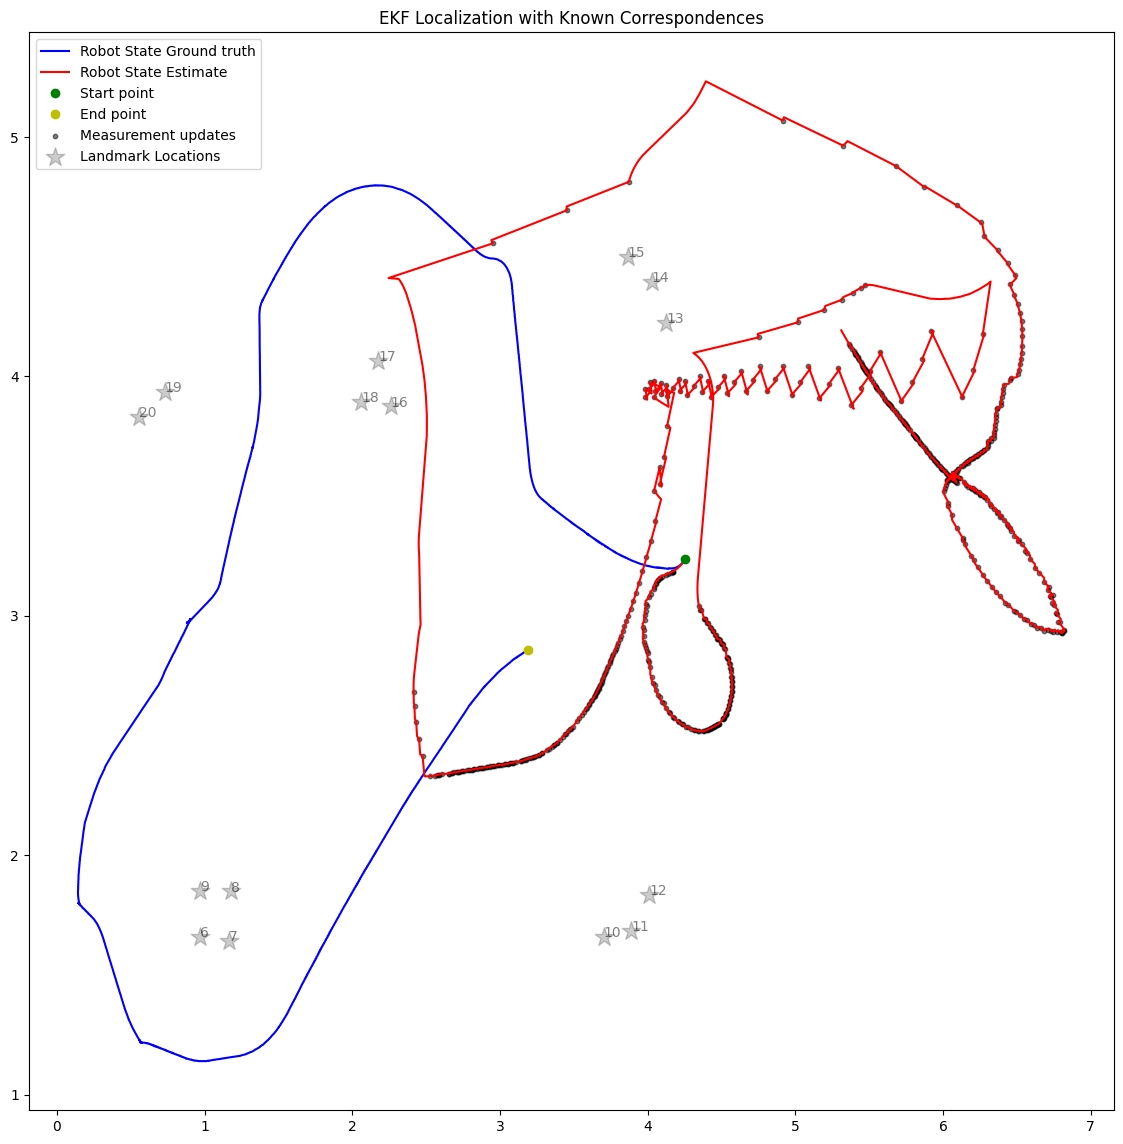

In [26]:
# Build Extended Kalman Filter object
R = np.diagflat(np.array([0.10, 0.10, 1.0]))** 2 
Q = np.diagflat(np.array([100, 100, 1e16]))** 2
ekf = ExtendedKalmanFilter(dataset, robot, end_frame, R, Q, True)

La trayectoria estimada por el algoritmo `Extended Kalman Filter` en esta caso deja mucho que desear.

Una manera de solucionarlo sería probar otros valores de las matrices de covarianza del *motion model* `R` y
la del *measurement model* `Q`. Yo lo he probado de manera empírica ya que desconozco los mecanismos.

Aunque para la obtención de estos valores hay una serie de aspectos que se pueden tener en cuenta conociendo
lo que hacen cada una de ellas:
    
• La relación de magnitud entre R y Q es indicativa de la fiabilidad de los dos elementos de medida o
modelado. Así:

- Si `R < Q`: el modelo proporciona más fiabilidad sobre el vector de estado que la matriz de 
    salida (`self.sigma` $\Sigma_t$ ).

- Si `R < Q`:el modelo es menos fiable.
    
• Las matrices `R` y `Q`:

- La matriz R indica la fiabilidad que le damos al motion model. Habitualmente estos valores deben ajustarse 
experimentalmente.

- La matriz Q modela el ruido propio de los sensores y determina el impacto de observar sus medidas al estimar
el desplazamiento relativo del robot en cada caso.m

Veamos el mismo algoritmo con el mismo dataset y robot al que le cambiamos únicamente el valor de `R`:

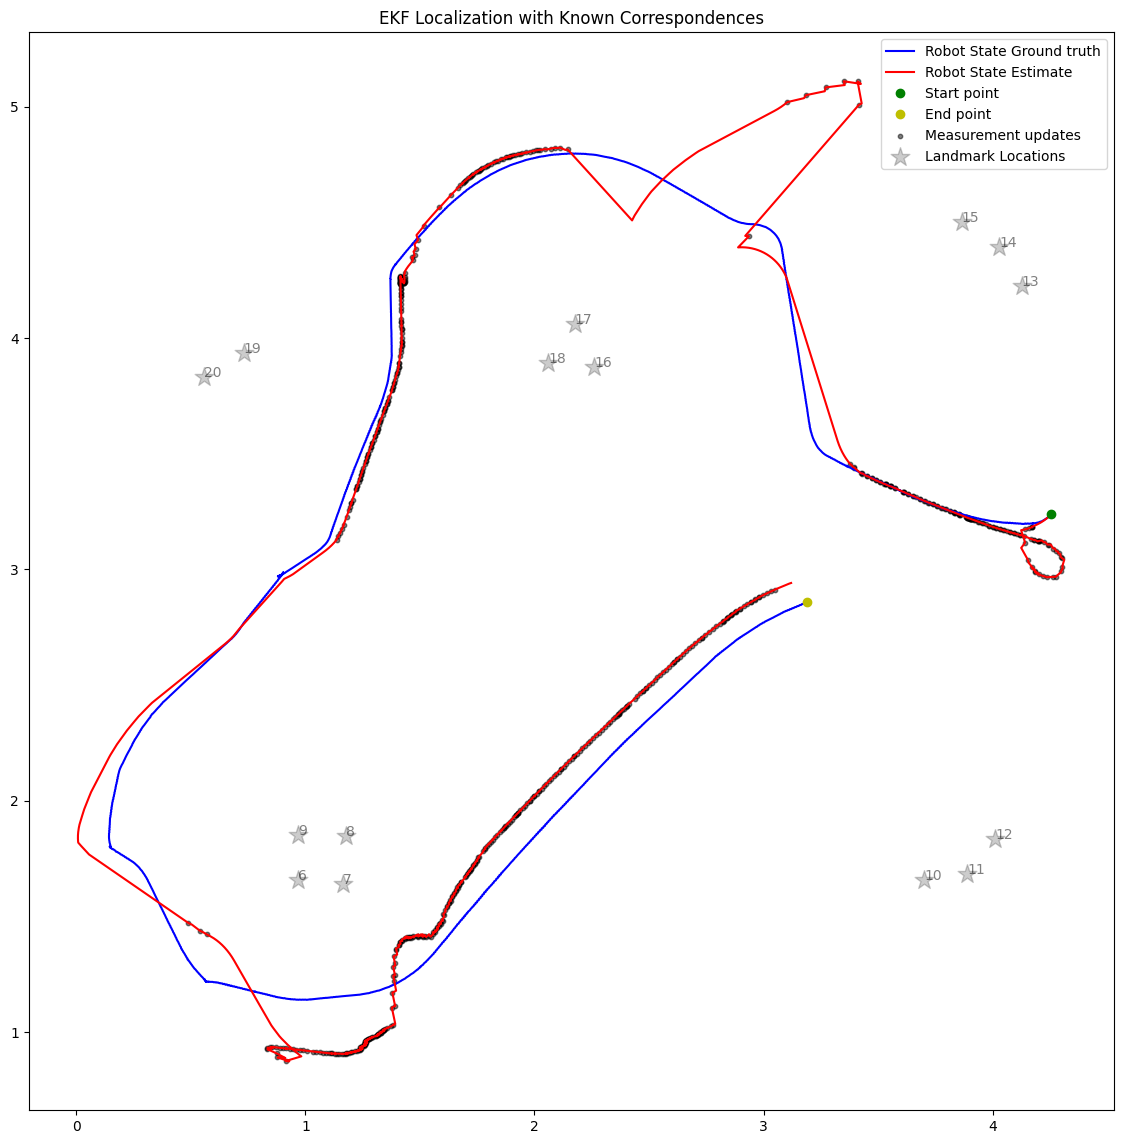

In [27]:
# Build Extended Kalman Filter object
R = np.diagflat(np.array([0.50, 0.50, 6.0]))** 2 
ekf = ExtendedKalmanFilter(dataset, robot, end_frame, R, Q, True)

Claramente tenemos una mejora sustancial respecto a la trayectoria anterior.

En concreto hemos sustituido la matriz

```python
R = np.diagflat(np.array([0.10, 0.10, 1.0]))** 2
```
por

```python
R = np.diagflat(np.array([0.50, 0.50, 6.0]))** 2
```

### Escenario del Mejor Caso (Worst Case Scenario). Fila 5

Esta fila se corresponde al dataset `data/MRCLAM_Dataset2` y al `Robot1`

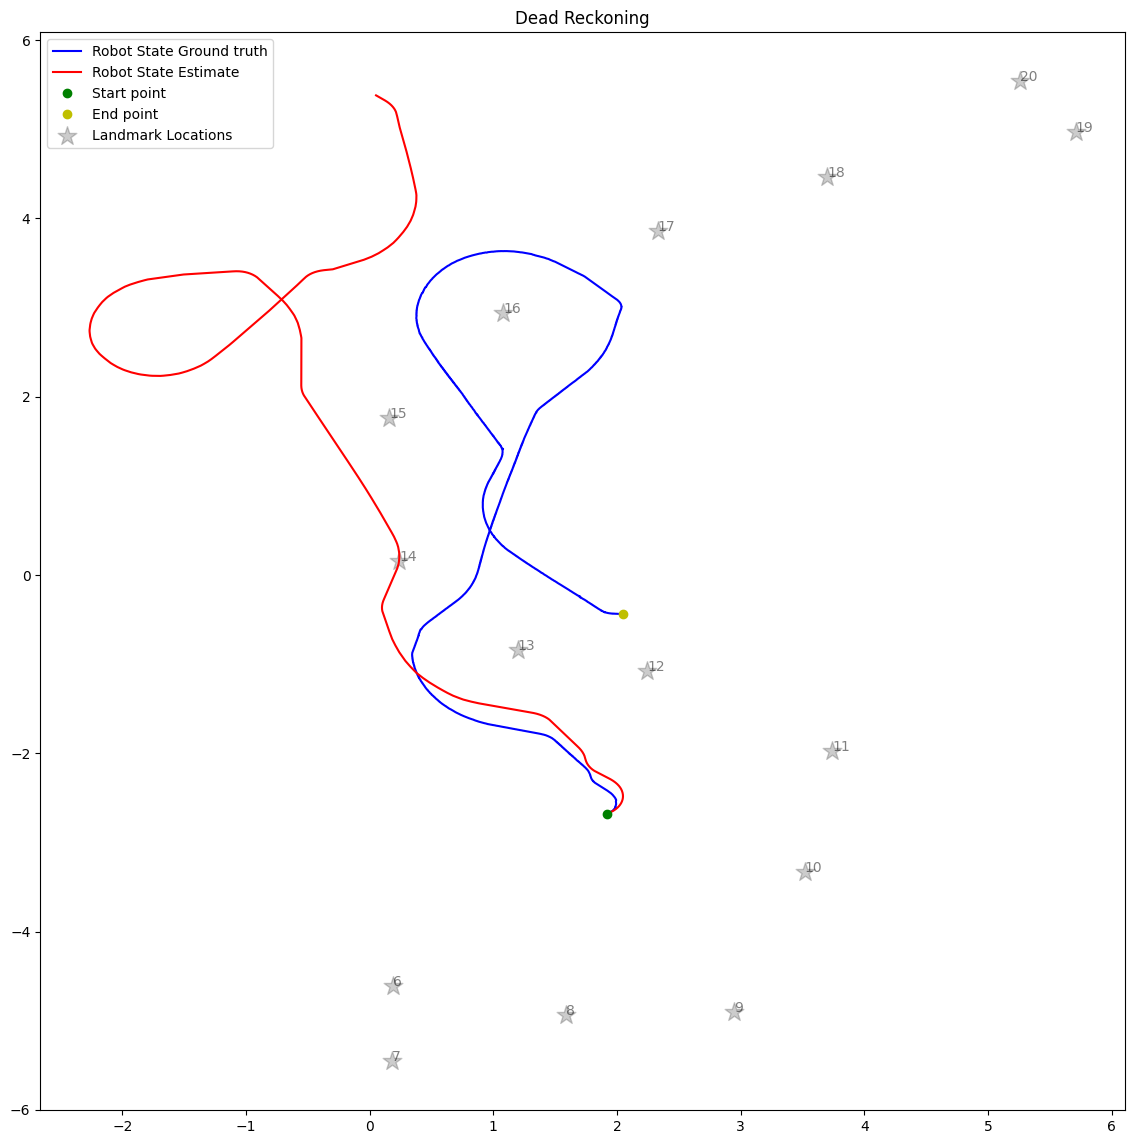

In [28]:
# Define dataset to read
dataset = "data/MRCLAM_Dataset2" # Dataset
end_frame = 15000 # Extension of the dataset
robot = 'Robot1' # Robot

# Build dead reckoning object
dr = DeadReckoning(dataset, robot, end_frame)
dr.run()

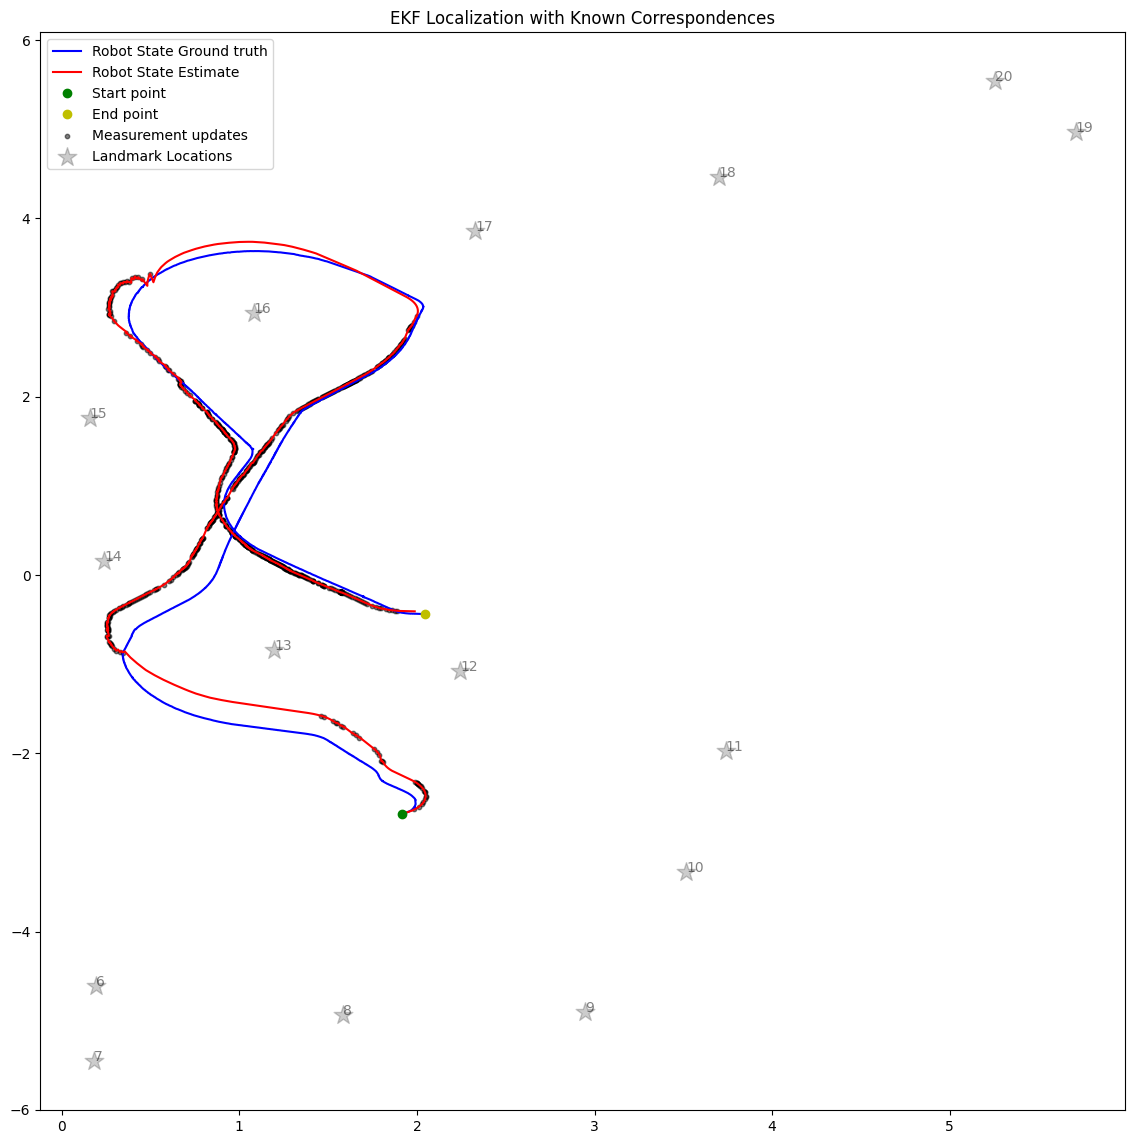

In [29]:
# Build Extended Kalman Filter object
R = np.diagflat(np.array([0.10, 0.10, 1.0]))** 2 
Q = np.diagflat(np.array([100, 100, 1e16]))** 2
ekf = ExtendedKalmanFilter(dataset, robot, end_frame, R, Q, True)